In [62]:
pip
install
lightgbm

NameError: name 'pip' is not defined

In [54]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

import numpy as np

# Load your dataset
data = pd.read_csv(r'C:\Users\user\PycharmProjects\DAE\Data\heart_statlog_cleveland_hungary_final.csv', index_col=0)

# Split the data into features and target
y = data['target']
X = data.drop(columns=['target'])

lgb_data = lgb.Dataset(X, label=y)

# split into train valid and test
X_TRAIN, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_TRAIN, y_train, test_size=0.25,
                                                  stratify=y_train)  # 0.25 x 0.8 = 0.2

# Checking columns types based on train and valid data so we can catch most of the values
bool_columns = [col for col in X_TRAIN.columns if X_TRAIN[col].nunique() == 2]
real_positive_columns = [col for col in X_TRAIN.columns if X_TRAIN[col].nunique() > 20 and (X_TRAIN[col] > 0).all()]
real_columns = [col for col in X_TRAIN.columns if X_TRAIN[col].nunique() > 20 and not (X_TRAIN[col] > 0).all()]
non_categorical_columns = bool_columns + real_columns + real_positive_columns
# where the categorical has at least 2 unique values and maximum 20
categorical_columns = [col for col in X_train.columns if col not in non_categorical_columns]

scaler_pipeline = ColumnTransformer(
    transformers=[
        ('minmax_scaler', MinMaxScaler(), real_positive_columns),
        ('standard_scaler', StandardScaler(), real_columns),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough'  # Keep the rest of the columns (like boolean) as is
)

# Fit and transform the training data, and transform the validation and test data
X_train_transformed = scaler_pipeline.fit_transform(X_train)
X_val_transformed = scaler_pipeline.transform(X_val)
X_test_transformed = scaler_pipeline.transform(X_test)

# Get the correct feature names after transformations
feature_names = scaler_pipeline.get_feature_names_out()

# Create DataFrames with the correct column names
X_train = pd.DataFrame(X_train_transformed, columns=feature_names)
X_val = pd.DataFrame(X_val_transformed, columns=feature_names)
X_test = pd.DataFrame(X_test_transformed, columns=feature_names)

# Ensure that all sets have the same columns after one-hot encoding
X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Define parameters for LightGBM
params = {
    'objective': 'binary',  # Binary classification
    'metric': 'auc',  # AUC as the evaluation metric
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation using LightGBM
cv_scores = []
for train_index, val_index in kf.split(X_train):
    # Rename the split data inside the loop to avoid overwriting the original data
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    lgb_train = lgb.Dataset(X_train_fold, label=y_train_fold)
    lgb_val = lgb.Dataset(X_val_fold, label=y_val_fold)

    # Train the model
    model = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=[lgb_train, lgb_val], callbacks=[
        lgb.early_stopping(stopping_rounds=50)
    ])

    # Predict and calculate AUC
    y_pred = model.predict(X_val_fold)
    auc = roc_auc_score(y_val_fold, y_pred)
    cv_scores.append(auc)

# Print the AUC scores from cross-validation
print(f'Cross-Validation AUC scores: {cv_scores}')
print(f'Mean AUC: {np.mean(cv_scores)}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 306, number of negative: 265
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 297
[LightGBM] [Info] Number of data points in the train set: 571, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535902 -> initscore=0.143855
[LightGBM] [Info] Start training from score 0.143855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [58]:
new_data_with_nans = data.copy()
y= new_data_with_nans['target']
X = new_data_with_nans.drop(columns=['target'])

# Get the total number of columns
n_columns = len(X.columns)

# Split columns into 1/3, 1/2, and the remaining
cols_no_nan = X.columns[:n_columns // 4]  # 1/3 no NaN
cols_nan_20 = X.columns[n_columns // 4: (n_columns // 4) + (n_columns // 2)]  # 1/2 with 20% NaN
cols_nan_70 = X.columns[(n_columns // 4) + (n_columns // 2):]  # The rest with 70% NaN

# Introduce NaNs for columns with a 20% NaN rate
for col in cols_nan_20:
    n_nans = int(0.2 * len(X))  # 20% NaNs
    nan_indices = np.random.choice(X.index, size=n_nans, replace=False)
    X.loc[nan_indices, col] = np.nan

# Introduce NaNs for columns with a 70% NaN rate
for col in cols_nan_70:
    n_nans = int(0.4 * len(X))  # 70% NaNs
    nan_indices = np.random.choice(X.index, size=n_nans, replace=False)
    X.loc[nan_indices, col] = np.nan
    
# COMBINE X AND Y
new_data_with_nans = pd.concat([X, y], axis=1)

In [59]:
new_data_with_nans.to_csv("see.csv")

In [57]:
new_data_with_nans.isna()

,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
age,,,,,,,,,,,
40,False,False,True,True,True,True,True,True,True,True,False
49,False,False,True,True,True,True,True,True,True,True,False
37,False,False,True,True,False,True,True,True,True,True,False
48,False,False,True,True,True,True,True,True,True,True,False
54,False,False,True,True,True,True,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...
45,False,False,True,True,True,True,True,True,True,True,False
68,False,False,True,True,True,True,True,True,True,True,False
57,False,False,True,True,True,True,True,True,True,True,False


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 101, number of negative: 89
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2419
[LightGBM] [Info] Number of data points in the train set: 190, number of used features: 45
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.531579 -> initscore=0.126484
[LightGBM] [Info] Start training from score 0.126484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

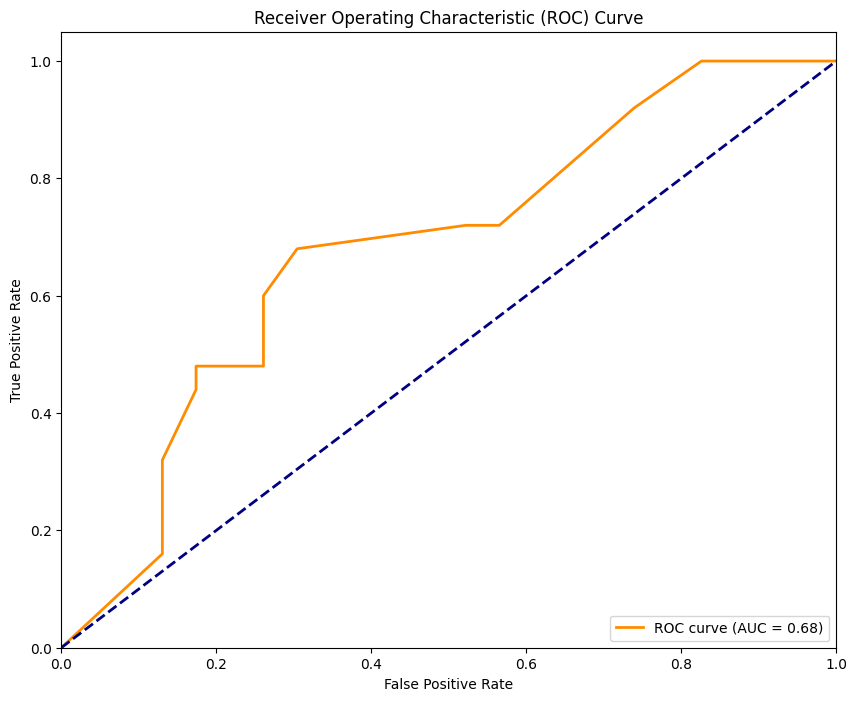

AUC: 0.6800
Feature importance ranking:
1. minmax_scaler__age (9.000000)
2. onehot__chest_pain_type_2 (9.000000)
3. onehot__resting_ecg_0.0 (8.000000)
4. standard_scaler__cholesterol (5.000000)
5. onehot__chest_pain_type_1 (5.000000)
6. onehot__resting_ecg_2.0 (3.000000)
7. onehot__resting_bp_s_100.0 (3.000000)
8. onehot__ST_slope_nan (2.000000)
9. onehot__exercise_angina_0.0 (2.000000)
10. onehot__max_heart_rate_160.0 (1.000000)
11. onehot__resting_bp_s_nan (1.000000)
12. onehot__chest_pain_type_4 (1.000000)
13. onehot__chest_pain_type_3 (1.000000)
14. onehot__oldpeak_nan (1.000000)
15. onehot__resting_bp_s_125.0 (0.000000)
16. onehot__fasting_blood_sugar_0.0 (0.000000)
17. onehot__resting_bp_s_136.0 (0.000000)
18. onehot__resting_bp_s_138.0 (0.000000)
19. onehot__resting_bp_s_120.0 (0.000000)
20. onehot__resting_bp_s_140.0 (0.000000)
21. onehot__resting_bp_s_143.0 (0.000000)
22. onehot__resting_bp_s_145.0 (0.000000)
23. onehot__resting_bp_s_155.0 (0.000000)
24. onehot__resting_bp_s_1

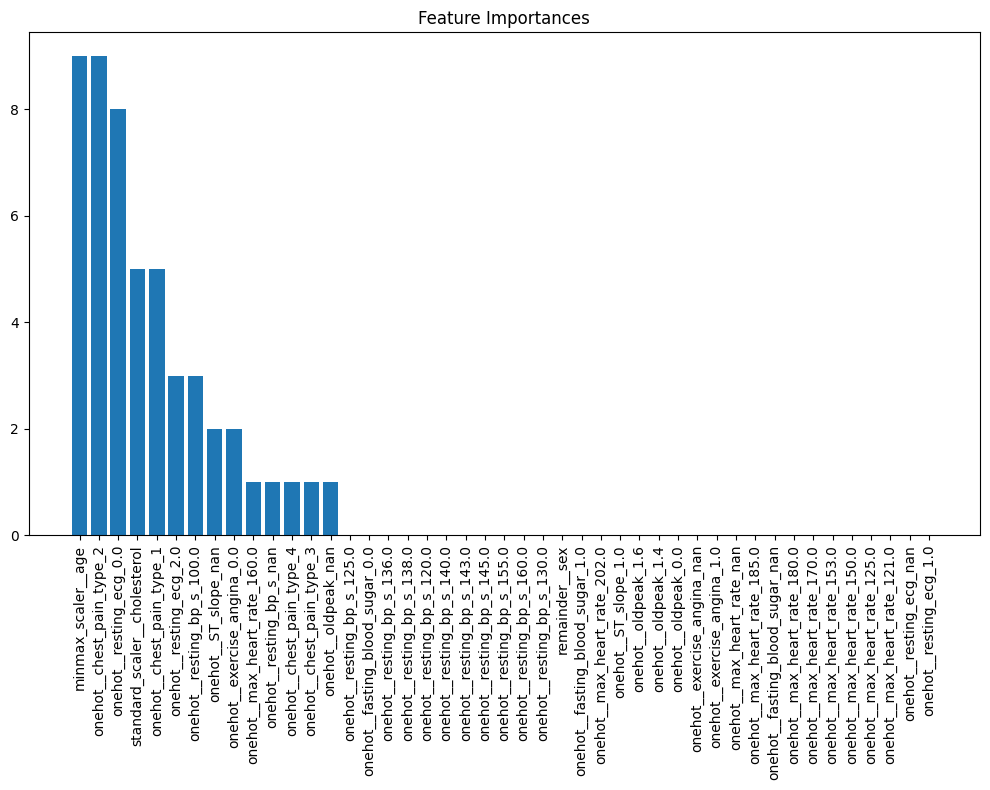

In [95]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

data = pd.read_csv('reconstructed.csv', index_col=0)
# y= data['target']
# X = data.drop(columns=['target'])
X = data
y = pd.read_csv('y_test.csv', index_col=0)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

print(f"AUC: {roc_auc:.4f}")

# Feature importance
feature_importance = model.feature_importance()
feature_names = model.feature_name()

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Print feature ranking
print("Feature importance ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], feature_importance[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importance[indices])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('reconstructed.csv', index_col=0)
X = data.values
y = pd.read_csv('y_test.csv', index_col=0).values.ravel()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

# Initialize the model
model = MLP(X_train.shape[1])

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('mlp_roc_curve.png')
plt.show()

print(f"AUC: {roc_auc:.4f}")

# Feature importance (using gradient-based method)
model.train()
X_train.requires_grad_()
outputs = model(X_train)
loss = criterion(outputs, y_train.unsqueeze(1))
loss.backward()

feature_importance = X_train.grad.abs().mean(0).numpy()

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Print feature ranking
print("Feature importance ranking:")
for f in range(X.shape[1]):
    print("%d. Feature %d (%f)" % (f + 1, indices[f], feature_importance[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importance[indices])
plt.xticks(range(X.shape[1]), [f"Feature {i}" for i in indices], rotation=90)
plt.tight_layout()
plt.savefig('mlp_feature_importance.png')
plt.show()

RuntimeError: all elements of input should be between 0 and 1